# Segmentação de Países da IMO por Desempenho

Notebook organizado a partir do script original (mantendo a mesma lógica e ordem de execução).

## 1. Setup, bibliotecas e carregamento dos dados

In [4]:
%pip install pandas numpy scikit-learn umap-learn matplotlib

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from umap import UMAP
from sklearn.cluster import KMeans

from sklearn.cluster import DBSCAN

from sklearn.metrics import silhouette_score, davies_bouldin_score

import matplotlib.pyplot as plt

Note: you may need to restart the kernel to use updated packages.


In [5]:
DATASET_URL = 'https://raw.githubusercontent.com/rfordatascience/tidytuesday/main/data/2024/2024-09-24/country_results_df.csv'

RANDOM_STATE = 314

In [6]:
df_imo_bronze = pd.read_csv(DATASET_URL)

df_imo_bronze.head()

,year,country,team_size_all,team_size_male,team_size_female,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions,leader,deputy_leader
0,2024,United States of America,6,5.0,1.0,42.0,41.0,19.0,40.0,35.0,15.0,NaN,5.0,1.0,0.0,0.0,John Berman,Carl Schildkraut
1,2024,People's Republic of China,6,6.0,0.0,42.0,42.0,31.0,40.0,22.0,13.0,NaN,5.0,1.0,0.0,0.0,Liang Xiao,Yijun Yao
2,2024,Republic of Korea,6,6.0,0.0,42.0,37.0,18.0,42.0,7.0,22.0,NaN,2.0,4.0,0.0,0.0,Suyoung Choi,Hwajong Yoo
3,2024,India,6,6.0,0.0,42.0,34.0,11.0,42.0,28.0,10.0,NaN,4.0,1.0,0.0,1.0,Krishnan Sivasubramanian,Rijul Saini
4,2024,Belarus,6,6.0,0.0,42.0,30.0,10.0,42.0,36.0,5.0,NaN,4.0,0.0,2.0,0.0,David Zmiaikou,Dzmitry Bazyleu


## 2. Camada Silver: seleção de colunas e conversão de tipos

In [7]:
colunas_camada_silver = [
  'country',
  'p1',
  'p2',
  'p3',
  'p4',
  'p5',
  'p6',
  'p7',
  'awards_gold',
  'awards_silver',
  'awards_bronze',
  'awards_honorable_mentions'
]

colunas_numericas = [
  'p1',
  'p2',
  'p3',
  'p4',
  'p5',
  'p6',
  'p7',
  'awards_gold',
  'awards_silver',
  'awards_bronze',
  'awards_honorable_mentions'
]

df_imo_silver = df_imo_bronze[colunas_camada_silver].copy()
df_imo_silver[colunas_numericas] = df_imo_silver[colunas_numericas].apply(pd.to_numeric, errors="coerce").fillna(0)

df_imo_silver


,country,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions
0,United States of America,42.0,41.0,19.0,40.0,35.0,15.0,0.0,5.0,1.0,0.0,0.0
1,People's Republic of China,42.0,42.0,31.0,40.0,22.0,13.0,0.0,5.0,1.0,0.0,0.0
2,Republic of Korea,42.0,37.0,18.0,42.0,7.0,22.0,0.0,2.0,4.0,0.0,0.0
3,India,42.0,34.0,11.0,42.0,28.0,10.0,0.0,4.0,1.0,0.0,1.0
4,Belarus,42.0,30.0,10.0,42.0,36.0,5.0,0.0,4.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
3775,Czechoslovakia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3776,Bulgaria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3777,Poland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3778,Union of Soviet Socialist Republics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## 3. Camada Gold: features derivadas (medalhas e proporções)

In [8]:
df_imo_gold = df_imo_silver.copy()

df_imo_gold["award_score"] = (
    df_imo_gold["awards_gold"] * 3 + df_imo_gold["awards_silver"] * 2 + df_imo_gold["awards_bronze"]
)

df_imo_gold["total_medals"] = (
    df_imo_gold["awards_gold"] + df_imo_gold["awards_silver"] + df_imo_gold["awards_bronze"] + df_imo_gold["awards_honorable_mentions"]
)

df_imo_gold["gold_ratio"] = (
    df_imo_gold["awards_gold"] / df_imo_gold["total_medals"]
).fillna(0)

df_imo_gold["silver_ratio"] = (
    df_imo_gold["awards_silver"] / df_imo_gold["total_medals"]
).fillna(0)

df_imo_gold["bronze_ratio"] = (
    df_imo_gold["awards_bronze"] / df_imo_gold["total_medals"]
).fillna(0)

df_imo_gold


,country,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions,award_score,total_medals,gold_ratio,silver_ratio,bronze_ratio
0,United States of America,42.0,41.0,19.0,40.0,35.0,15.0,0.0,5.0,1.0,0.0,0.0,17.0,6.0,0.833333,0.166667,0.000000
1,People's Republic of China,42.0,42.0,31.0,40.0,22.0,13.0,0.0,5.0,1.0,0.0,0.0,17.0,6.0,0.833333,0.166667,0.000000
2,Republic of Korea,42.0,37.0,18.0,42.0,7.0,22.0,0.0,2.0,4.0,0.0,0.0,14.0,6.0,0.333333,0.666667,0.000000
3,India,42.0,34.0,11.0,42.0,28.0,10.0,0.0,4.0,1.0,0.0,1.0,14.0,6.0,0.666667,0.166667,0.000000
4,Belarus,42.0,30.0,10.0,42.0,36.0,5.0,0.0,4.0,0.0,2.0,0.0,14.0,6.0,0.666667,0.000000,0.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3775,Czechoslovakia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1.0,1.000000,0.000000,0.000000
3776,Bulgaria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3777,Poland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
3778,Union of Soviet Socialist Republics,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.000000,0.000000,1.000000


## 4. Dataset por país (agregação)

In [9]:
df_imo_facts = (
    df_imo_gold.copy().groupby('country', as_index=False).agg(
        p1=("p1", "mean"),
        p2=("p2", "mean"),
        p3=("p3", "mean"),
        p4=("p4", "mean"),
        p5=("p5", "mean"),
        p6=("p6", "mean"),
        p7=("p7", "mean"),
        awards_gold=("awards_gold", "mean"),
        awards_silver=("awards_silver", "mean"),
        awards_bronze=("awards_bronze", "mean"),
        awards_honorable_mentions=("awards_honorable_mentions", "mean"),
        award_score=("award_score", "mean"),
        total_medals=("total_medals", "mean"),
        gold_ratio=("gold_ratio", "mean"),
        silver_ratio=("silver_ratio", "mean"),
        bronze_ratio=("bronze_ratio", "mean"),
    )
)

df_imo_facts


,country,p1,p2,p3,p4,p5,p6,p7,awards_gold,awards_silver,awards_bronze,awards_honorable_mentions,award_score,total_medals,gold_ratio,silver_ratio,bronze_ratio
0,Albania,15.222222,4.703704,0.518519,12.703704,3.703704,0.518519,0.0,0.000000,0.074074,0.333333,1.666667,0.481481,2.074074,0.000000,0.027778,0.126543
1,Algeria,11.869565,6.608696,0.913043,11.956522,3.739130,0.826087,0.0,0.043478,0.086957,0.347826,1.043478,0.652174,1.521739,0.008696,0.032609,0.099275
2,Angola,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,Argentina,28.305556,14.388889,4.527778,24.361111,12.638889,2.666667,0.0,0.166667,0.777778,2.000000,1.416667,4.055556,4.361111,0.035185,0.179630,0.461574
4,Armenia,28.030303,15.939394,3.333333,27.787879,13.212121,1.575758,0.0,0.030303,0.909091,2.303030,1.393939,4.212121,4.636364,0.015152,0.183333,0.486869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,Uzbekistan,22.000000,16.173913,0.826087,22.782609,9.478261,0.739130,0.0,0.000000,0.521739,1.521739,2.173913,2.565217,4.217391,0.000000,0.109420,0.323913
135,Venezuela,8.064516,2.193548,0.483871,6.741935,1.967742,0.774194,0.0,0.000000,0.064516,0.161290,0.870968,0.290323,1.096774,0.000000,0.021505,0.053763
136,Vietnam,35.416667,30.125000,15.437500,34.083333,28.041667,11.770833,0.0,1.437500,2.437500,1.770833,0.062500,10.958333,5.708333,0.248958,0.427083,0.313542
137,Yugoslavia,24.135135,21.135135,13.702703,22.270270,19.054054,12.081081,0.0,0.162162,1.243243,2.594595,0.189189,5.567568,4.189189,0.031081,0.282883,0.649099


## 5. Preparação da matriz X e normalização

In [10]:
X = df_imo_facts[colunas_numericas].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 6. PCA: projeção 2D e variância explicada

PC1: 0.6548427047651615
PC2: 0.15909455218010035
Total: 0.8139372569452619


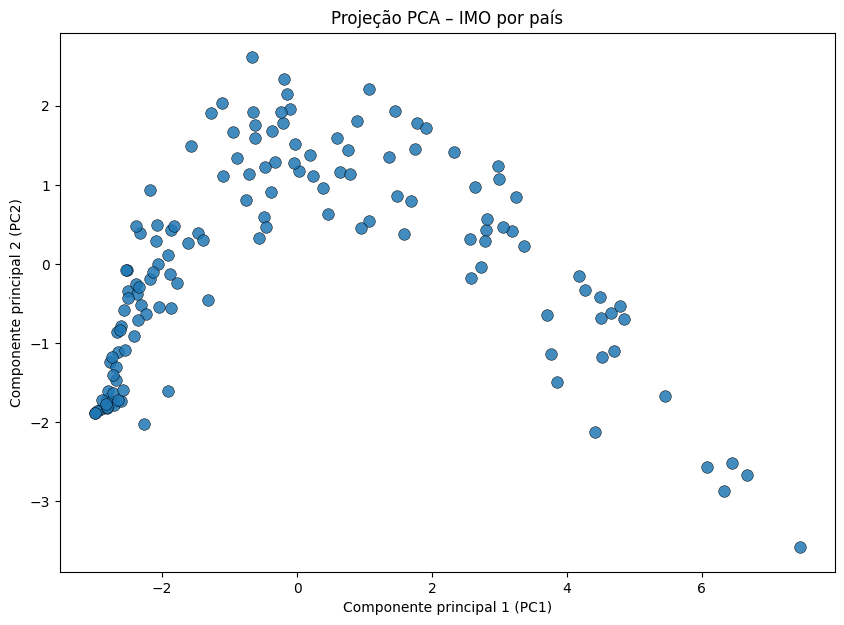

,Componente,Variância explicada,Percentual
0,PC1,0.6548,65.48%
1,PC2,0.1591,15.91%
2,Total,0.8139,81.39%


In [11]:
pca = PCA(n_components=2, random_state=RANDOM_STATE)

X_pca = pca.fit_transform(X_scaled)

var_pc1 = pca.explained_variance_ratio_[0]
var_pc2 = pca.explained_variance_ratio_[1]
total = var_pc1 + var_pc2

print("PC1:", var_pc1)
print("PC2:", var_pc2)
print("Total:", total)

plt.figure(figsize=(10, 7))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    s=70,
    alpha=0.85,
    edgecolor="black",
    linewidth=0.4
)

plt.xlabel("Componente principal 1 (PC1)")
plt.ylabel("Componente principal 2 (PC2)")
plt.title("Projeção PCA – IMO por país")
plt.show()

var_pc1 = pca.explained_variance_ratio_[0]
var_pc2 = pca.explained_variance_ratio_[1]
total = var_pc1 + var_pc2

df_var = pd.DataFrame({
    "Componente": ["PC1", "PC2", "Total"],
    "Variância explicada": [var_pc1, var_pc2, total],
    "Percentual": [var_pc1*100, var_pc2*100, total*100],
})

df_var["Variância explicada"] = df_var["Variância explicada"].map("{:.4f}".format)
df_var["Percentual"] = df_var["Percentual"].map("{:.2f}%".format)

df_var


## 7. K-Means no espaço PCA

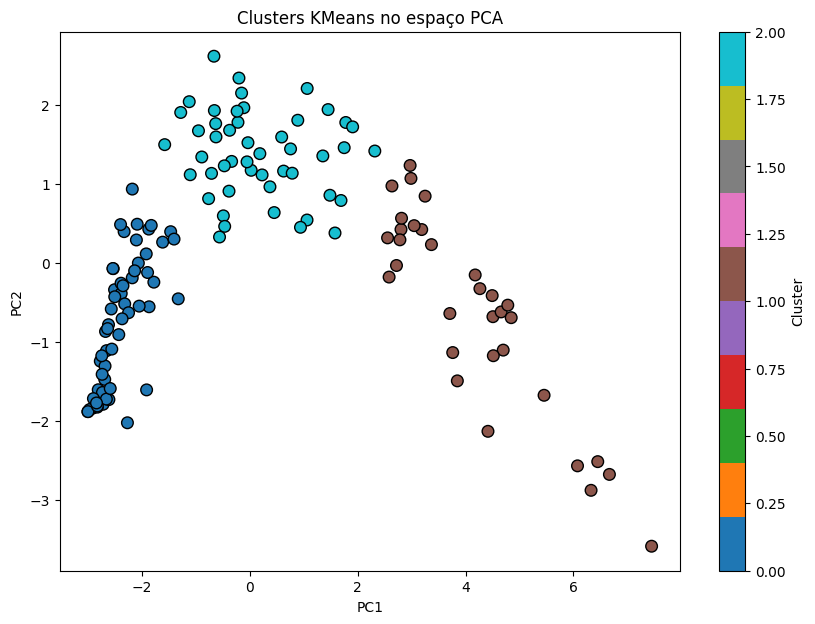


Cluster 0 — 59 países:
Albania, Algeria, Angola, Bahrain, Benin, Bhutan, Bolivia, Botswana, Brunei, Burkina Faso, Cambodia, Cameroon, Chile, Cuba, Cyprus, Dominican Republic, Ecuador, Egypt, El Salvador, Gambia, Ghana, Guatemala, Honduras, Iceland, Iraq, Ireland, Ivory Coast, Jamaica, Kenya, Kosovo, Kuwait, Kyrgyzstan, Laos, Liechtenstein, Luxembourg, Madagascar, Mauritania, Montenegro, Mozambique, Myanmar, Nepal, Nicaragua, Nigeria, Oman, Pakistan, Palestine, Panama, Paraguay, Puerto Rico, Rwanda, Tanzania, Trinidad and Tobago, Tunisia, Turkish Republic of Northern Cyprus, Uganda, United Arab Emirates, Uruguay, Venezuela, Zimbabwe

Cluster 1 — 32 países:
Australia, Belarus, Bulgaria, Canada, Commonwealth of Independent States, Czechoslovakia, Democratic People's Republic of Korea, France, German Democratic Republic, Germany, Hong Kong, Hungary, India, Islamic Republic of Iran, Israel, Japan, People's Republic of China, Poland, Republic of Korea, Romania, Russian Federation, Serbia, S

,Métrica,Valor
0,Silhouette,0.5793
1,Davies-Bouldin,0.5591


In [12]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
labels_kmeans = kmeans.fit_predict(X_pca)

plt.figure(figsize=(10, 7))
plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=labels_kmeans,
    s=70,
    cmap="tab10",
    edgecolor="black",
)

plt.title("Clusters KMeans no espaço PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label="Cluster")
plt.show()

df_clusters_kmeans = df_imo_facts.copy()
df_clusters_kmeans["cluster_kmeans"] = labels_kmeans

for cluster_id in sorted(df_clusters_kmeans["cluster_kmeans"].unique()):
    countries = df_clusters_kmeans[df_clusters_kmeans["cluster_kmeans"] == cluster_id]["country"].tolist()
    print(f"\nCluster {cluster_id} — {len(countries)} países:")
    print(", ".join(countries))

sil_k = silhouette_score(X_pca, labels_kmeans)
db_k = davies_bouldin_score(X_pca, labels_kmeans)

print("KMeans + PCA")
print("Silhouette:", sil_k)
print("Davies-Bouldin:", db_k)

sil_k = silhouette_score(X_pca, labels_kmeans)
db_k  = davies_bouldin_score(X_pca, labels_kmeans)

df_metrics_kmeans = pd.DataFrame({
    "Métrica": ["Silhouette", "Davies-Bouldin"],
    "Valor": [sil_k, db_k]
})

df_metrics_kmeans["Valor"] = df_metrics_kmeans["Valor"].map(lambda x: f"{x:.4f}")

df_metrics_kmeans


## 8. UMAP: variação de hiperparâmetros (visual)

/home/joao/dev/ufrn/aprendizado-nao-supervisionado/projeto-aprendizado-nao-supervisionado/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/joao/dev/ufrn/aprendizado-nao-supervisionado/projeto-aprendizado-nao-supervisionado/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/joao/dev/ufrn/aprendizado-nao-supervisionado/projeto-aprendizado-nao-supervisionado/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/joao/dev/ufrn/aprendizado-nao-supervisionado/projeto-aprendizado-nao-supervisionado/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  wa

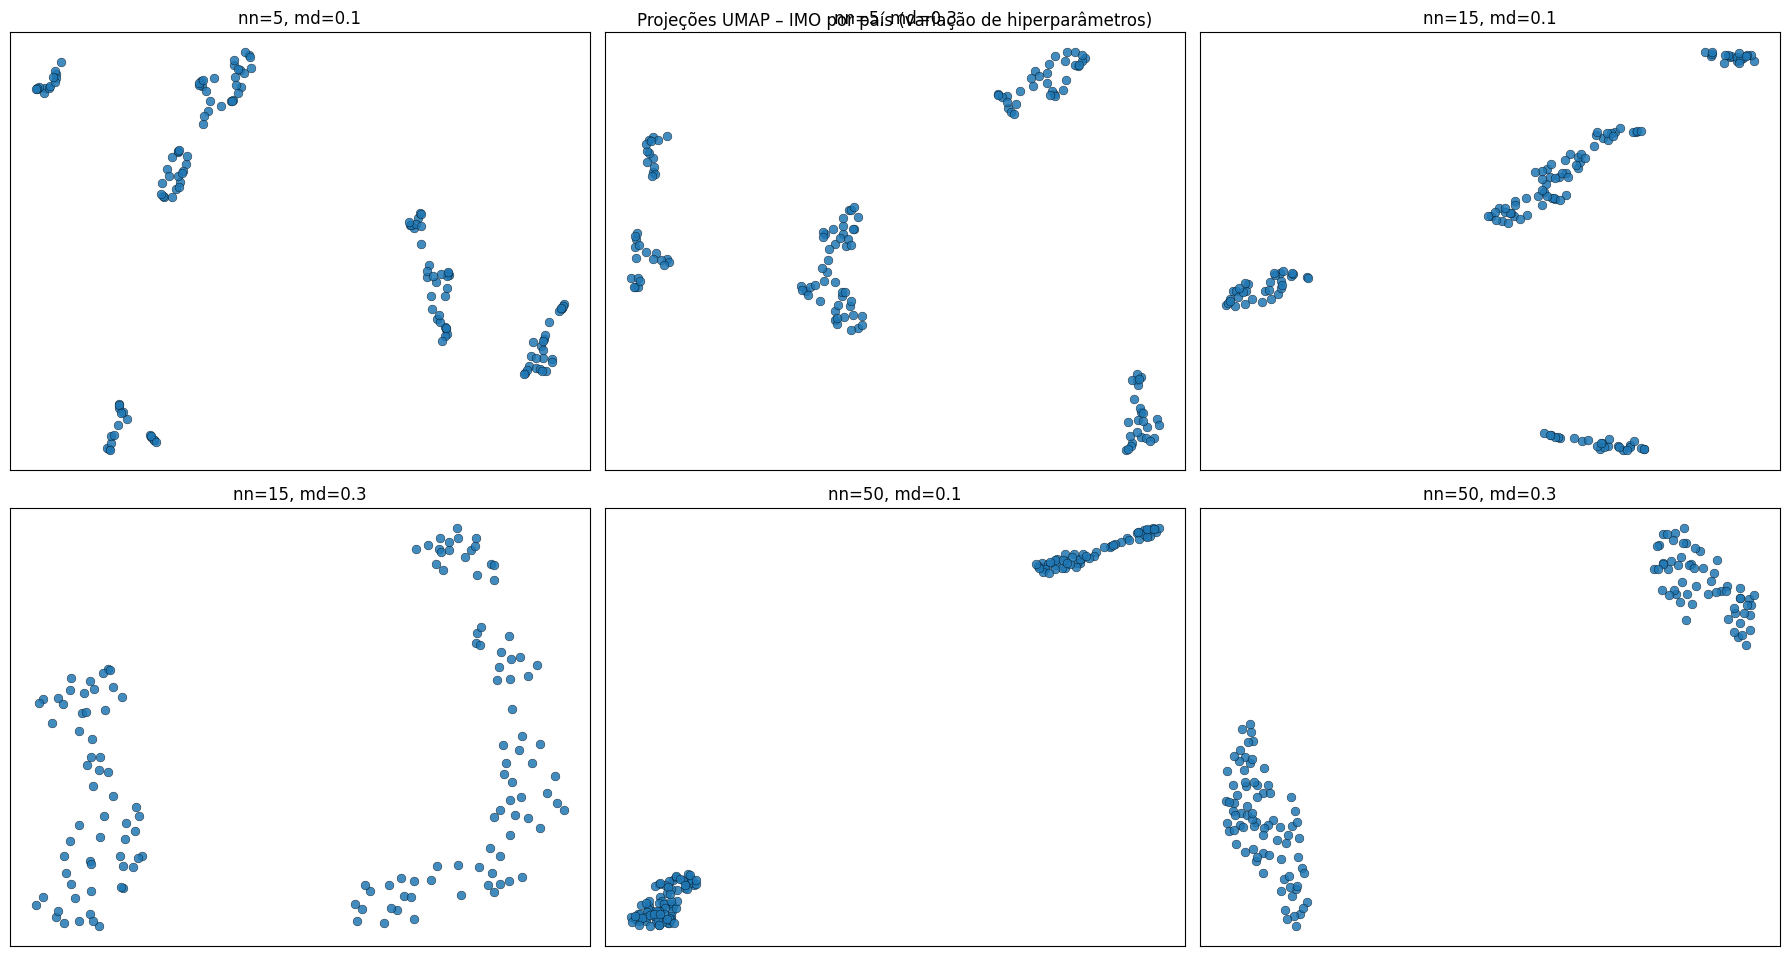

In [13]:
configuracoes = [
    {"name": "nn=5, md=0.1",  "n_neighbors": 5,  "min_dist": 0.1},
    {"name": "nn=5, md=0.3",  "n_neighbors": 5,  "min_dist": 0.3},
    {"name": "nn=15, md=0.1", "n_neighbors": 15, "min_dist": 0.1},
    {"name": "nn=15, md=0.3", "n_neighbors": 15, "min_dist": 0.3},
    {"name": "nn=50, md=0.1", "n_neighbors": 50, "min_dist": 0.1},
    {"name": "nn=50, md=0.3", "n_neighbors": 50, "min_dist": 0.3},
]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, cfg in zip(axes.ravel(), configuracoes):
    umap = UMAP(
        n_neighbors=cfg["n_neighbors"],
        min_dist=cfg["min_dist"],
        random_state=RANDOM_STATE,
    )
    X_umap_cfg = umap.fit_transform(X_scaled)

    ax.scatter(
        X_umap_cfg[:, 0],
        X_umap_cfg[:, 1],
        s=40,
        alpha=0.85,
        edgecolor="black",
        linewidth=0.3,
    )
    ax.set_title(f'{cfg["name"]}')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("Projeções UMAP – IMO por país (variação de hiperparâmetros)", y=0.95)
plt.tight_layout()
plt.show()


## 9. UMAP: projeção escolhida

/home/joao/dev/ufrn/aprendizado-nao-supervisionado/projeto-aprendizado-nao-supervisionado/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


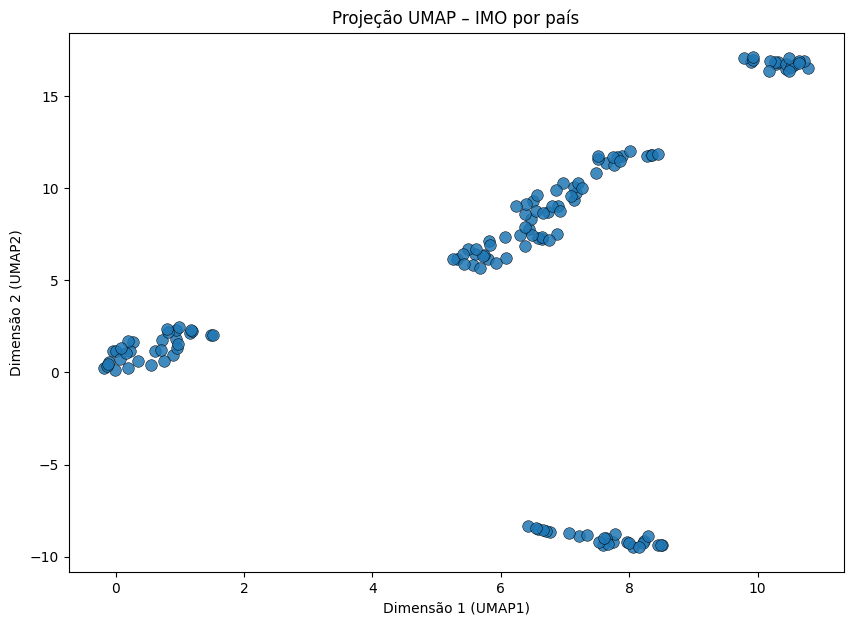

In [14]:
umap = UMAP(n_neighbors=15, min_dist=0.1, random_state=RANDOM_STATE)

X_umap = umap.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    s=70,
    alpha=0.85,
    edgecolor="black",
    linewidth=0.4
)

plt.xlabel("Dimensão 1 (UMAP1)")
plt.ylabel("Dimensão 2 (UMAP2)")
plt.title("Projeção UMAP – IMO por país")
plt.show()


## 10. DBSCAN no espaço UMAP: clusters e países por cluster

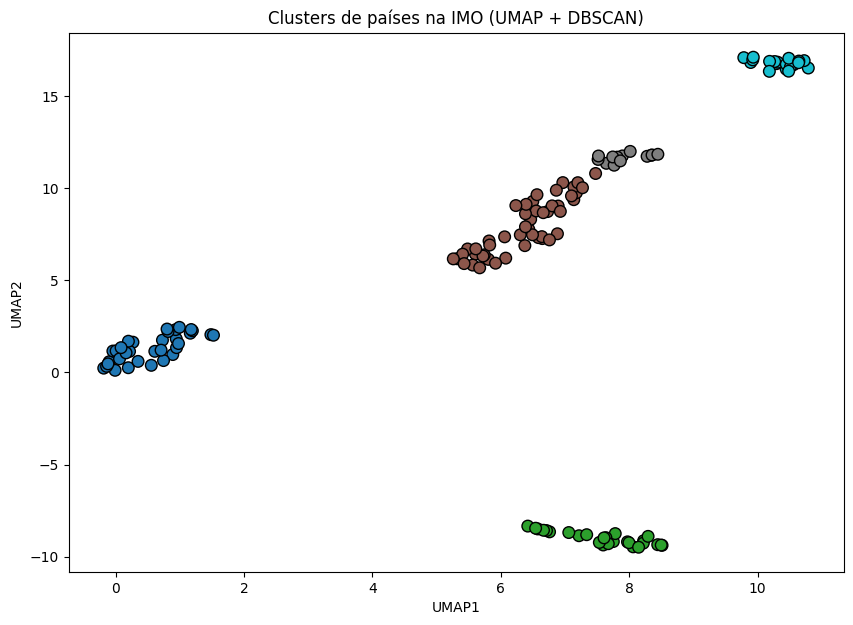


Cluster 0 — 33 países:
Albania, Algeria, Bolivia, Cambodia, Chile, Cuba, Cyprus, Dominican Republic, Ecuador, El Salvador, Honduras, Iceland, Ireland, Ivory Coast, Kosovo, Kyrgyzstan, Luxembourg, Mauritania, Montenegro, Myanmar, Nepal, Nicaragua, Nigeria, Pakistan, Palestine, Panama, Paraguay, Puerto Rico, Rwanda, Trinidad and Tobago, Tunisia, Uruguay, Venezuela

Cluster 1 — 26 países:
Angola, Bahrain, Benin, Bhutan, Botswana, Brunei, Burkina Faso, Cameroon, Egypt, Gambia, Ghana, Guatemala, Iraq, Jamaica, Kenya, Kuwait, Laos, Liechtenstein, Madagascar, Mozambique, Oman, Tanzania, Turkish Republic of Northern Cyprus, Uganda, United Arab Emirates, Zimbabwe

Cluster 2 — 48 países:
Argentina, Armenia, Austria, Azerbaijan, Bangladesh, Belgium, Bosnia and Herzegovina, Brazil, Colombia, Costa Rica, Croatia, Czech Republic, Denmark, Estonia, Finland, Georgia, Greece, Indonesia, Italy, Kazakhstan, Latvia, Lithuania, Macau, Malaysia, Mexico, Mongolia, Morocco, Netherlands, New Zealand, North Ma

In [15]:
dbscan = DBSCAN(eps=0.7, min_samples=5)

labels_dbscan = dbscan.fit_predict(X_umap)

df_clusters_dbscan = df_imo_facts.copy()
df_clusters_dbscan["cluster"] = labels_dbscan

plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=df_clusters_dbscan["cluster"],
    s=70,
    cmap="tab10",
    edgecolor="black",
)

handles, _ = scatter.legend_elements()

plt.title("Clusters de países na IMO (UMAP + DBSCAN)")
plt.xlabel("UMAP1")
plt.ylabel("UMAP2")
plt.show()

df_clusters_dbscan = df_imo_facts.copy()
df_clusters_dbscan["cluster"] = labels_dbscan

pais_por_cluster = (
    df_clusters_dbscan
    .groupby("cluster")["country"]
    .apply(list)
)

for cluster_id, countries in pais_por_cluster.items():
    print(f"\nCluster {cluster_id} — {len(countries)} países:")
    print(", ".join(countries))


## 11. Avaliação: métricas (DBSCAN + UMAP)

In [16]:
mask = labels_dbscan != -1
X_umap_no_noise = X_umap[mask]
labels_no_noise = labels_dbscan[mask]

sil_d = silhouette_score(X_umap_no_noise, labels_no_noise)
db_d = davies_bouldin_score(X_umap_no_noise, labels_no_noise)

print("DBSCAN + UMAP")
print("Silhouette:", sil_d)
print("Davies-Bouldin:", db_d)

mask = labels_dbscan != -1
X_umap_no_noise = X_umap[mask]
labels_no_noise = labels_dbscan[mask]

sil = silhouette_score(X_umap_no_noise, labels_no_noise)
db  = davies_bouldin_score(X_umap_no_noise, labels_no_noise)

df_metrics = pd.DataFrame({
    "Métrica": ["Silhouette", "Davies-Bouldin"],
    "Valor": [sil, db]
})

df_metrics["Valor"] = df_metrics["Valor"].map(lambda x: f"{x:.4f}")

df_metrics


DBSCAN + UMAP
Silhouette: 0.742735743522644
Davies-Bouldin: 0.2811696445258159


,Métrica,Valor
0,Silhouette,0.7427
1,Davies-Bouldin,0.2812
